# Classification

In [1]:
# %load ../helpers/header.py
# load ENV path to project from .profile 
import os, sys
PROJECT_ROOT_DIR=os.environ.get('ML_PATH')
sys.path.append(os.path.join(PROJECT_ROOT_DIR, "helpers")) # add helper modules to path

# MPL 
import MPL_header #load common MPL imports (from helpers)
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib widget 

# NP, constant seed, PD 
import numpy as np
np.random.seed(12345)
import pandas as pd

# Where to save the figures
SUB_DIR = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig", SUB_DIR)
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig")
os.makedirs(IMAGES_PATH, exist_ok=True)

ModuleNotFoundError: No module named 'ipympl'

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
print("70k digits, each 28x28=784 pixels", X.shape, y.shape, "each pixel goes from 0(White)-255(Black), e.g. X[12][323]=", X[12][323])

70k digits, each 28x28=784 pixels (70000, 784) (70000,) each pixel goes from 0(White)-255(Black), e.g. X[12][323]= 249.0


### Plot a digit

5 looks like this


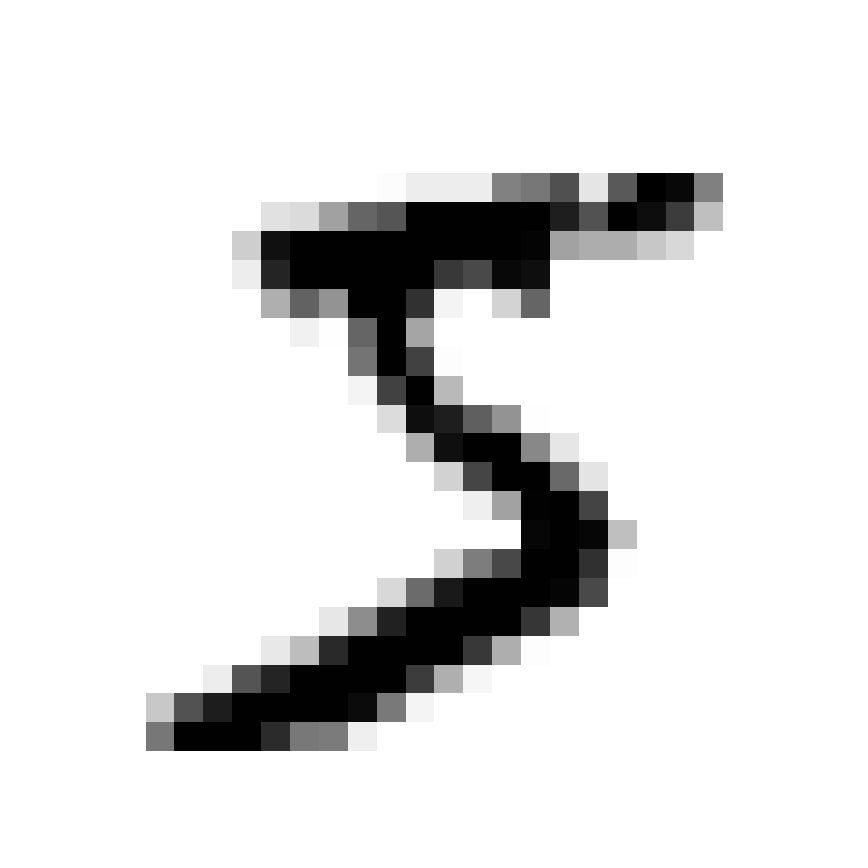

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary");
plt.axis("off");
print(y[0], "looks like this")

In [6]:
print("Object/string....,", y.dtype)
y = y.astype(np.uint8)
print("Casting to int....,", y.dtype)

Object/string...., object


NameError: name 'np' is not defined

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Already shuffled - good! Ensures: a) folds have equal split b) no repeatability in training. Shuffling is not good for e.g. time-series data (e.g. stcoks)

#  Binary Classifier: only try to say '5' or 'not 5'

In [8]:
# T/F 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=1234)
sgd_clf.fit(X_train, y_train_5)

ValueError: The number of classes has to be greater than one; got 1 class

In [10]:
sgd_clf.predict([some_digit])

IndexError: tuple index out of range

# Performance Measures

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([nan, nan, nan])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
print("Accuracy is not the best metric for classifiers...(generally)")
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

Accuracy is not the best metric for classifiers...(generally)


NameError: name 'np' is not defined

### Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict
#instead of scores, returns the actual predictions (clean, predictions are on the validation fold)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

ValueError: The number of classes has to be greater than one; got 1 class

In [15]:
from sklearn.metrics import confusion_matrix
# (true, pred)
confusion_matrix(y_train_5, y_train_pred)

NameError: name 'y_train_pred' is not defined

### Row = actual class, column= predicted class
CM_00 = TN, CM_11 =TP, CM_10 = FN, CM_01 = FP

### Accuracy = $\frac{TP+TN}{TP+TN+FP+FN}$
Precision = $\frac{TP}{TP+FP}$  (<ins>**penalty for mis-firing (over-classifing)**</ins>, "how well did it trigger?"/percentage of your results which are relevant)

### Really, need a second metric (otherwise e.g. 1/1=100%, not constrained).
Recall (sensitivity or true positive rate (TPR)) = $\frac{\rm{TP}}{\rm{TP+FN}}$ (**<ins>penalty for "missed out cases"/ (how well did it trigger given truth) (under-classifiing)</ins>**/percentage of total relevant results correctly classified by your algorithm)

<img src="../docs/CM.png" width="600">

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4296 / (4296 + 1152)

NameError: name 'y_train_pred' is not defined

In [17]:
recall_score(y_train_5, y_train_pred) # == 4296/ (4296+1125)

NameError: name 'y_train_pred' is not defined

#### Harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.
$$F_1 = \frac{2}{\frac{1}{\rm{precision}}+\frac{1}{\rm{recall}}}=2\times\frac{\rm{precision}\times\rm{recall}}{\rm{precision}+\rm{recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

NameError: name 'y_train_pred' is not defined

### The F1 score favors classifiers that have similar precision and recall. This is not always what you want! (e.g. if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision))

In [19]:
y_scores = sgd_clf.decision_function([some_digit]); y_scores

IndexError: tuple index out of range

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold); y_some_digit_pred

NameError: name 'y_scores' is not defined

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

NameError: name 'y_scores' is not defined

In [22]:
#return scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

ValueError: The number of classes has to be greater than one; got 1 class

In [23]:
# using scores -> prec/reacall for all THRs
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

NameError: name 'y_scores' is not defined

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

NameError: name 'precisions' is not defined